# Homework 5 - Explore California and Nevada with graphs
---
Here we import every library we'll need.

In [3]:
import networkx as nx
import numpy as np
from collections import deque

---
## Graph class
Here we're going to create our graph class which we're going to use for basically every task. Since we'll use a lot of nodes and every node shouldn't be connected to many edges (considering that our graph represents a map of roads) we'll use an djacency list to represent the graph. An adjacency matrix would take too much memory and most of the entries would be zero, so it would be really inefficient.

We're going to assume we'll work with undirected graphs, so we implement a class consequentially.

In [4]:
# This class is going to represent a graph, so that we can organize all the implementation and methods of
# our data structure in an organized way
class Graph:
    
    # This constructur takes as parameter the number of nodes
    def __init__(self, size):
        self._nodes = [[] for _ in range(size)]
        self._nodes_features = [{} for _ in range(size)]
        
    # This method adds features to a node in the form of a dictionary
    def add_features_to_node(self, node, features, replace = False):
        if(replace):
            self._nodes_features[node - 1] = features
        else:
            for key in features.keys():
                self._nodes_features[node - 1][key] = features[key]
                
    # This method is for removing all given features from the nodes of the graph, or all features if no second
    # parameter is given
    def reset_features(self, features = None):
        if(features is None):
            for index in range(len(self._nodes_features)):
                self._nodes_features[index] = {}
        else:
            for index in range(len(self._nodes_features)):
                for feature in features:
                    self._nodes_features[index].pop(feature, None)
        
    # This method is for getting features of a node
    def get_feature_of_node(self, node, feature):
        moment = self._nodes_features[node - 1]
        if(feature in moment.keys()):
            return(moment[feature])
        return(None)
        
    # This method adds an edge to the graph, together with an optional dict of weights
    # The edge is given as a tuple of nodes
    def add_edge(self, edge, weights = None, check = None):
        if(check):
            for neighbour in self.get_neighbours(edge[0]):
                if(neighbour == edge[1]):
                    return(None)
        to_add = (edge[1] - 1, {})
        if(not weights is None):
            to_add = (edge[1] - 1, weights)
        self._nodes[edge[0] - 1].append(to_add)
        
        to_add = (edge[0] - 1, {})
        if(not weights is None):
            to_add = (edge[0] - 1, weights)
        self._nodes[edge[1] - 1].append(to_add)
        
    # This method gets all neighbours of a node and given weights of the edges connecting them to the node
    def get_neighbours(self, node, features = None):
        if(features is None):
            return([single_node[0] + 1 for single_node in self._nodes[node - 1]])
        to_return = []
        for neighbour in self._nodes[node - 1]:
            to_return.append((neighbour[0] + 1, dict((k, neighbour[1][k]) for k in features if k in neighbour[1])))
        return(to_return)
    
    # This method get an edge from the graph together with the specified weights
    # If the edge doesn't exist it returns None
    def get_edge(self, node_one, node_two, features = None):
        for neighbour in self._nodes[node_one - 1]:
            if(neighbour[0] == node_two - 1):
                if(features is None):
                    return((node_one, node_two))
                return((node_one, node_two, dict((k, neighbour[1][k]) for k in features if k in neighbour[1])))
        return(None)
    
    # This method updates and edge adding more weights or replacing them (based on replace parameter)
    # It doesn't do anything if the edge doesn't exist
    def update_edge(self, node_one, node_two, weights):
        for neighbour in self._nodes[node_one - 1]:
            if(neighbour[0] == node_two - 1):
                for key in weights.keys():
                    neighbour[1][key] = weights[key]
                return
            
    # This method creates and returns the subgraph of this subgraph containing all the nodes in set_of_nodes
    # and all the edges connecting them
    # with_reference parameter estabilishes if this subgraph should have reference to nodes of starting graph
    # as features
    # features parameter estabilishes what edges features should be mantained
    def get_complete_subgraph(self, set_of_nodes, features, with_reference = False):
        to_return = Graph(len(set_of_nodes))
        list_set_of_nodes = [0]
        list_set_of_nodes.extend(list(set_of_nodes))
        for index in range(len(set_of_nodes)):
            for neighbour in self.get_neighbours(list_set_of_nodes[index + 1], features):
                if(neighbour[0] in set_of_nodes):
                    to_return.add_edge((index + 1, list_set_of_nodes.index(neighbour[0])), neighbour[1], check = True)
        if(with_reference):
            for index in range(len(set_of_nodes)):
                to_return.add_features_to_node(index + 1, {"Reference node" : list_set_of_nodes[index + 1]})
        return(to_return)
        
            
    # This method prints the adjacency list of the graph, it will be used just to check that everything works fine
    def print_graph(self, head = None):
        if(head is None):
            head = len(self._nodes)
        for index in range(head):
            print(index + 1, end = " : ")
            print([(node[0] + 1, node[1]) for node in self._nodes[index]])

---
# 1 - Data collection
Here we're going to use the files we have downloaded to create and populate our graph of interest. To start we need to count how many nodes we need so we can correctly create our graph.

In [5]:
counter = 0
nodes = open("adm_hw5/USA-road-d.CAL.co" , "r")
while(True):
    string = nodes.readline()
    if(string == ""):
        break
    if(string[0] == 'v'):
        counter = counter + 1
nodes.close()
print(counter)

1890815


Now that we know our graph will contain $1890815$ nodes we can create it.

In [6]:
CAL = Graph(1890815)

Now we're going to populate our graph wiht edges. Since every edge appear four times in total in our files (twice per file), we need some caution in doing this. In fact we have to be aware that our graph doesn't see if an edge already exists before adding it and since it's an undirected graph class we don't need to add every edge twice (one for direction).

In [7]:
times = open("adm_hw5/USA-road-t.CAL.gr", "r")
distances = open("adm_hw5/USA-road-d.CAL.gr", "r")
counter = 0
while(True):
    string_time = times.readline()
    string_distance = distances.readline()
    if(string_time == ""):
        break
    if(string_time[0] == 'a' and (counter % 2) == 1):
        edge_time = string_time.split(" ")
        edge_distance = string_distance.split(" ")
        CAL.add_edge((int(edge_time[1]), int(edge_time[2])), {"Time" : int(edge_time[3]), "Distance" : int(edge_distance[3])})  
    counter = counter + 1
times.close()
distances.close()

# 2 - Implementation of the backend

---
## Shortest path in a graph
In order to solve a lot of tasks we'll need a way to find the shortest path connecting two nodes in a graph. This is a common problem and we'll implement two different algorithms to accomplish our goal.

The first one is the breadth-first-search to find out what the minimum path connecting two nodes in a graph is, whitout taking into consideration any weight. Then we'll implement the Dijkstra's algorithm to find the shortest path based on a certain weight.

### Breadth-first-search
Here we implement our breadth-first-search algorithm. Since we want it to work for graphs belonging to our class we're going to implement this method like it belongs to our <code>Graph</code> class and then use <code>seatattr()</code> to actually add it to the class.

In [8]:
# This method finds the shortest path connecting a source and a target node using a breadth-first-search
# It returns None if not such a path exists
def breadth_first_search(self, source, target):
    in_queue_nodes = deque()
    
    in_queue_nodes.appendleft(source)
    self.add_features_to_node(source, {"Visited" : True})
    while(True):
        if(not in_queue_nodes):
            self.reset_features(["Visited", "Parent"])
            return(None)
        visiting_now = in_queue_nodes.pop()
        if(visiting_now == target):
            break
        for neighbour in self.get_neighbours(visiting_now):
            if(self.get_feature_of_node(neighbour, "Visited") is None):
                in_queue_nodes.appendleft(neighbour)
                self.add_features_to_node(neighbour, {"Parent" : visiting_now, "Visited" : True})
    
    to_return = []
    while(not visiting_now is None):
        to_return.append(visiting_now)
        visiting_now = self.get_feature_of_node(visiting_now, "Parent")
    self.reset_features(["Visited", "Parent"])
    
    return(to_return[::-1])

setattr(Graph, 'breadth_first_search', breadth_first_search)

### Dijkstra algorithm
Here we implement our Dijkstra algorithm which we'll use to find the shortest path in a graph connecting two nodes taking into considerations weights. Before we can code the algorithm we need an heap to store nodes and extracting them.

We're going to use a binaryl heap, which should be enough to make an efficient algorithm. We could use a Binomial heap or a Fibonacci heap, but it would be a lot more complicated and, considered constant factors, it's not even guaranteed to gain much efficiency.

So let's start defining our <code>Binary_Heap</code> class. We're going to represent it as a list <code>heap</code> where every entry is a node and children of <code>heap[i]</code> are <code>heap[2i]</code> and <code>heap[2i + 1]</code>. The binary heap is associated with an <code>int_function</code> which converts nodes to integer used for comparison.

In [9]:
# This class represents a binary heap using a list.
class Binary_Heap:
    
    # This constructor is for creating a binary heap containing a single node
    def __init__(self, single_node, int_function = lambda x : x):
        self._heap = [None, single_node]
        self._int_function = int_function
    
    # This constructor is for getting left child of a node given his index, None if not such a child exists
    def get_left_child(self, node_index):
        position = node_index * 2
        if(position >= len(self._heap)):
            return(None)
        return(self._heap[position])
    
    # Like left child, but for right child
    def get_right_child(self, node_index):
        position = (node_index * 2) + 1
        if(position >= len(self._heap)):
            return(None)
        return(self._heap[position])
    
    # This constructor is for getting parent of a node given is index, None if not such a parent exists
    def get_parent(self, node_index):
        return(self._heap[node_index // 2])
    
    # This is the heapify function, it helps preserving the properties of the heap
    def heapify(self, index):
        left = 2 * index
        right = (2 * index) + 1
        minimum = index
        if(left < len(self._heap) and self._int_function(self._heap[left]) < self._int_function(self._heap[minimum])):
            minimum = left
        if(right < len(self._heap) and self._int_function(self._heap[right]) < self._int_function(self._heap[minimum])):
            minimum = right
        if(minimum != index):
            aux = self._heap[index]
            self._heap[index] = self._heap[minimum]
            self._heap[minimum] = aux
            self.heapify(minimum)
        
    # This function is for inserting a new node inside the heap
    def insert(self, new_node):
        if(len(self._heap) == 1):
            self._heap.append(new_node)
            return
        self._heap.append(new_node)
        index = len(self._heap) - 1
        while(self._int_function(self._heap[index]) < self._int_function(self.get_parent(index))):
            aux = self._heap[index]
            self._heap[index] = self.get_parent(index)
            self._heap[index // 2] = aux
            index = index // 2
            if(index // 2 == 0):
                return
    
    # This function is for extracting the minimum element from the heap
    def extract(self):
        if(len(self._heap) == 2):
            return(self._heap.pop())
        to_return = self._heap[1]
        self._heap[1] = self._heap.pop()
        self.heapify(1)
        return(to_return)
    
    # Method for checking if the heap is empty
    def is_empty(self):
        return(len(self._heap) == 1)

Now we can implement our Dijkstra algorithm.

In [10]:
# Dijkstra's algorithm, it finds the shortest path in a graph connecting source and target taking into consideration
# the given weight.
def dijkstra(self, source, target, weight):
    heap = Binary_Heap((source, 0), lambda x : x[1])
    self.add_features_to_node(source, {"Distance" : 0})
    while(True):
        if(heap.is_empty()):
            self.reset_features(["Visited", "Distance", "Parent"])
            return(None)
        current_node = heap.extract()
        if(current_node[0] == target):
            break
        if(self.get_feature_of_node(current_node[0], "Visited")):
            continue
        this_distance = self.get_feature_of_node(current_node[0], "Distance")
        for close_node in self.get_neighbours(current_node[0], [weight]):
            prev_distance = self.get_feature_of_node(close_node[0], "Distance")
            arc_weight = close_node[1][weight]
            new_distance = this_distance + arc_weight
            if(prev_distance is None or prev_distance > new_distance):
                self.add_features_to_node(close_node[0], {"Distance" : new_distance, "Parent" : current_node[0]})
                heap.insert((close_node[0], new_distance))
        self.add_features_to_node(current_node[0], {"Visited" : True})
    
    current_node = current_node[0]
    to_return = []
    while(not current_node is None):
        to_return.append(current_node)
        current_node = self.get_feature_of_node(current_node, "Parent")
    self.reset_features(["Visited", "Distance", "Parent"])
    return(to_return[::-1])

setattr(Graph, 'dijkstra', dijkstra)

## Functionality 1 -  Find the Neighbours!

This following function  <i> getNeigh </i> get 3 differrent parameters:
* v = current node
* nodeList = it is an initially empty list that will contain all nodes visited
* typeDistance = one of the three possible distance= time, distance (metres) or network distance

This fucntion returns a list of all nodes visited, i.e. the result of our functionality 1.

We use a recursive function becuase we inseet a node in the nides visited list in thee following way:
* about distance or time: we iterate all neighbour from node v and we recursively subtract every time the distance from initial threshold distance and we add this neighbour to our nodeList. When the current distance has an higher value than remaining distance, we stop to substract and we'll pass to other neighbour to previous node.
* about networkDistance: we iterate all neighbours recursively. For every edge that link current node to its neighbour we substract 1 to input threshold distance and we add this current neighbour to our nodeList. When this remaining distance has a value = 0, we stop and we'll pass to another neighbour to previous node.

In [11]:

def getNeigh(v,nodeList,d,typeDistance):
    #add current node in nodeList 
    if v not in nodeList:
        nodeList.append(v)
    #case of typeDistance=NetworkDistance    
    if typeDistance=="NetworkDistance":
        #get neighbours of current node v
        neighbours=CAL.get_neighbours(v)
        #iterate all neighbours
        for i in range(len(CAL.get_neighbours(v))):
            #get edge betwwen node v and current neighbours
            edge=CAL.get_edge(v,neighbours[i])
            #check if we can put this neighbours in nodeList
            if not d==0 and neighbours[i] not in nodeList:
                
                nodeList.append(neighbours[i])
                
                getNeigh(neighbours[i],nodeList,d-1,typeDistance)
        
        return nodeList
        
    else:
        #case of typeDistance is not NetworkDistance, i.e. it is 'Distance' or 'Time'
        
        #get neighbours with its information(time or distance) of current node v
        neighbours=CAL.get_neighbours(v,[typeDistance])
        
        #iterate all neighbours of node v
        for i in range(len(CAL.get_neighbours(v,[typeDistance]))):
            
            #get edge between node v and current its neighbour
            edge=CAL.get_edge(v,neighbours[i][0],[typeDistance])
            
            #check if we can put current neighbour in nodeList
            if edge[2][typeDistance] < d and neighbours[i][0] not in nodeList:
             
                nodeList.append(neighbours[i][0])
                
                getNeigh(neighbours[i][0],nodeList,d-edge[2][typeDistance],typeDistance)
        
        
        return nodeList

---
## Functionality 2 - Find the smartest Network!
In this section we're going to implement the second requested functionality. To solve the problem we're going to use Prim's algorithm for finding the minimum spanning tree of a graph.

The idea is the following: given our graph as well as our set of nodes we want to be able to visit, we consider the subgraph consisting of all the nodes we want to visit and all the edges connecting them. We then extract the minimum spanning tree from this subgraph and that will be the solution to our problem. In fact note that a minimum set of edges is always a tree (or we can remove an edge and still have a connected graph), so the minimum spanning tree is the answer to our problem.

Let's jump into the algorithm.

In [12]:
# This functin applies Prim's algorithm to a graph for finding minimum spanning tree
# weight parameter estabilishes which weight to use to choose the minimum tree
def prim_algorithm(self, weight = None):
    set_of_roads = set()
    heap = Binary_Heap((1, 0), lambda x : x[1])
    while(not heap.is_empty()):
        current_node = heap.extract()
        if(self.get_feature_of_node(current_node[0], "In tree")):
            continue
        self.add_features_to_node(current_node[0], {"In tree" : True})
        other_node = self.get_feature_of_node(current_node[0], "Chosen edge")
        set_of_roads.add(other_node)
        if(other_node):
            self.add_features_to_node(other_node[1], {"In tree" : True})
        for neighbour in self.get_neighbours(current_node[0], [weight]):
            if(self.get_feature_of_node(neighbour[0], "In tree")):
                continue
            if(weight):
                distance = neighbour[1][weight]
            else:
                distance = 1
            prev_distance = self.get_feature_of_node(neighbour[0], "Distance")
            if(prev_distance is None or prev_distance > distance):
                self.add_features_to_node(neighbour[0], {"Distance" : distance, "Chosen edge" : (neighbour[0], current_node[0])})
                heap.insert((neighbour[0], distance))
    self.reset_features(["Distance", "Chosen edge", "In tree"])
    return(set_of_roads)

setattr(Graph, 'prim_algorithm', prim_algorithm)

Now, in order to find the minimum spanning tree of a subcollection of nodes of our graph, we're going to change a little the algorithm and work with our functio to get subgraphs.

This will be our second functionality.

In [13]:
# This function applied Prim's algorithm to a complete subgraph of the graph
def smartest_network(self, set_of_nodes, weight = None):
    subgraph = self.get_complete_subgraph(set_of_nodes, [weight], with_reference = True)
    set_of_edges = subgraph.prim_algorithm(weight)
    to_return = set()
    for edge in set_of_edges:
        if(edge is None):
            continue
        start = edge[0]
        end = edge[1]
        real_start = subgraph.get_feature_of_node(start, "Reference node")
        real_end = subgraph.get_feature_of_node(end, "Reference node")
        to_return.add((real_start, real_end))
    return(to_return)

setattr(Graph, "smartest_network", smartest_network)

---
## Functionality 3 - Shortest Ordered Route
In this section we're going to implement functionality 3. Most of the work associated to it comes from finding the shortest path in a graph connecting two nodes and since we have already done that this will be a quick task.

We start from a simple, but fundamental observation: given a node $H$ and a sequence of nodes $p_{1}, \dots, p_{n}$ let $s_{i}$ be the shortest path going from $H$ to $p_{n}$ as asked by the functionality ($s_{i}$ is the $i$-th node taken by the path). Then for every couple of consecutive nodes $p_{j}, p_{j + 1}$ (or $H, p_{1}$) the subpath of $s_{i}$ connecting $p_{j}$ and $p_{j + 1}$ is the shortest path in the graph connecting $p_{j}$ and $p_{j + 1}$. In fact, if that's not the case we could substitute this subpath with the shortest path and we would get a shorter path than $s_{i}$ satisfying our properties.

Considered this, to find the path asked by the functionality we just need to find the shortest path connecting two nodes sequentially: first for $H$ and $p_{1}$, then for $p_{1}$ and $p_{2}$ etc. etc.

So let's do this. As always we're going to code a function and then we'll add it to our <code>Graph</code> class with the <code>setattr</code> method.

In [89]:
# This class finds the shortest ordered route given a sequence of nodes and based on a certain distance, if no
# distance is specified it uses the network distance
# The method uses Dijkstra when a distance is specified or Breadth-First-Search for network distance
# The function returns None if not such a route exists
def shortest_ordered_route(self, H, sequence_of_nodes, distance = None):
    route = [H]
    sequence = [H]
    sequence.extend(sequence_of_nodes)
    for index in range(len(sequence) - 1):
        if(distance is None):
            sub_route = self.breadth_first_search(sequence[index], sequence[index + 1])
        else:
            sub_route = self.dijkstra(sequence[index], sequence[index + 1], distance)
        if(sub_route is None):
            return(None)
        route.extend(sub_route[1:])
    return(route)

setattr(Graph, 'shortest_ordered_route', shortest_ordered_route)

---
## Functionality 4 - Shortest Route
In this section we're going to implement functionality 4. Since the complexity of this task is really high, we're not coding an exact solution, but an approximate one which, we hope, will be enough efficient.

To partially solve the problem we're going to change a little Dijkstra's algorithm in such a way that it stops when it finds *any* of the nodes in the list of nodes expected by the route. Once the algorithm has stopped it start again from zero, but with the new node as start node and a reduced list expected by the route.

To accomplish this task we go for a recursive approach since it seems pretty suited for this. Moreover, just like functions in functionality 3, we're going code the function and add it to our <code>Graph</code> class.

In [90]:
# This function finds an approximate shortest route starting from a node H and passing through all the nodes
# in set_of_nodes, everything in a weighted graph, with weight given by weight parameter
def shortest_route_dijkstra(self, H, set_of_nodes, weight):
    if(len(set_of_nodes) == 0):
        return([])
    
    for node in set_of_nodes:
        self.add_features_to_node(node, { "In set" : True})
    heap = Binary_Heap((H, 0), lambda x : x[1])
    self.add_features_to_node(H, { "Distance" : 0 })
    while(True):
        if(heap.is_empty()):
            self.reset_features(["Visited", "Distance", "Parent", "In set"])
            return(None)
        current_node = heap.extract()
        if(self.get_feature_of_node(current_node[0], "In set")):
            break
        if(self.get_feature_of_node(current_node[0], "Visited")):
            continue
        this_distance = self.get_feature_of_node(current_node[0], "Distance")
        for close_node in self.get_neighbours(current_node[0], [weight]):
            prev_distance = self.get_feature_of_node(close_node[0], "Distance")
            arc_weight = close_node[1][weight]
            new_distance = this_distance + arc_weight
            if(prev_distance is None or prev_distance > new_distance):
                self.add_features_to_node(close_node[0], {"Distance" : new_distance, "Parent" : current_node[0]})
                heap.insert((close_node[0], new_distance))
        self.add_features_to_node(current_node[0], {"Visited" : True})
        
    current_node = current_node[0]
    set_of_nodes.remove(current_node)
    new_H = current_node
    aux_list = []
    while(not current_node is None):
        aux_list.append(current_node)
        current_node = self.get_feature_of_node(current_node, "Parent")
    self.reset_features(["Visited", "Distance", "Parent", "In set"])
    aux_list = aux_list[::-1]
    recursion_list = self.shortest_route_dijkstra(new_H, set_of_nodes, weight)
    if(recursion_list is None):
        return(None)
    aux_list.extend(recursion_list[1:])
    return(aux_list)

setattr(Graph, 'shortest_route_dijkstra', shortest_route_dijkstra)

We're now going to do this change we have just done to Dijkstra, but to BFS so that the algorithm works in an efficient way when handling network distance. (Just like in functionality 3).

In [91]:
# This function is like shortest_route_dijkstra, but with unweighted graphs, so it doesn't need a weight parameter
def shortest_route_bfs(self, H, set_of_nodes):
    if(len(set_of_nodes) == 0):
        return([])
    for node in set_of_nodes:
        self.add_features_to_node(node, {"In set" : True})
    in_queue_nodes = deque()
    in_queue_nodes.appendleft(H)
    self.add_features_to_node(H, {"Visited" : True})
    while(True):
        if(not in_queue_nodes):
            self.reset_features(["Visited", "Parent", "In set"])
            return(None)
        visiting_now = in_queue_nodes.pop()
        if(self.get_feature_of_node(visiting_now, "In set")):
            break
        for neighbour in self.get_neighbours(visiting_now):
            if(self.get_feature_of_node(neighbour, "Visited") is None):
                in_queue_nodes.appendleft(neighbour)
                self.add_features_to_node(neighbour, {"Parent" : visiting_now, "Visited" : True})
    
    set_of_nodes.remove(visiting_now)
    new_H = visiting_now
    aux_list = []
    while(not visiting_now is None):
        aux_list.append(visiting_now)
        visiting_now = self.get_feature_of_node(visiting_now, "Parent")
    aux_list = aux_list[::-1]
    self.reset_features(["Visited", "Parent", "In set"])
    recursion_list = self.shortest_route_bfs(new_H, set_of_nodes)
    if(recursion_list is None):
        return(None)
    aux_list.extend(recursion_list[1:])
    return(aux_list)

setattr(Graph, 'shortest_route_bfs', shortest_route_bfs)

We're now going to code the fourth functionality and get everything done together.

In [97]:
# This is the function which solves our fourth functionality
def shortest_route(self, H, set_of_nodes, distance = None):
    if(distance is None):
        return(self.shortest_route_bfs(H, set_of_nodes))
    else:
        return(self.shortest_route_dijkstra(H, set_of_nodes, distance))
    
setattr(Graph, "shortest_route", shortest_route)

# 3 - Implementation of the frontend

## Visualization 1 - Visualize the Neighbours!

Node Color:
* Red = started node
* cyan = nodes from func1 result

Edge color:
* Black = NetworkDistance
* Purple = Time
* Red = Distance(metres)

In [78]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(15,15)
def drawGraph_Func1(result, typeDistance):
    G = nx.Graph()
    E_color=''
    
    for i in result:
        G.add_node(i)


        for i in result:

            for j in result:
                edge=CAL.get_edge(i,j,[typeDistance])
                
                if not edge==None:
                    G.add_edge(i,j)
    if not nx.is_empty(G):
        colors = ["red"] + (["cyan"] * (len(result) - 1))
        pos=nx.spring_layout(G)  #<<<<<<<<<< Initialize this only once
        nx.draw(G,pos, with_labels=True, font_size=25)
        nx.draw_networkx_nodes(G,pos,node_color= colors, node_size = 1000)
        if typeDistance=="Distance":
            nx.draw_networkx_edges(G, pos,edge_color='blue', width=3)
        elif typeDistance=="Time":
            nx.draw_networkx_edges(G, pos,edge_color='purple', width=3)
        else:
            nx.draw_networkx_edges(G, pos,edge_color='red', width=3)
        
        plt.show()

## Visualization 2 - Visualize the smartest Network!

Edge color:
* Black = NetworkDistance
* Purple = Time
* Red = Distance(metres)
* Black = edge that are not in output edges

In [79]:
import matplotlib.pyplot as plt

#plt.rcParams["figure.figsize"]=(15,15)
def drawGraph_Func2(result,typeDistance,set_nodes):
    G = nx.Graph()
    for node in set_nodes:
        G.add_node(node)
    
    for i in set_nodes:

            for j in set_nodes:
                edge=CAL.get_edge(i,j,[typeDistance])
                
                if not edge==None:
                    G.add_edge(i,j)
    
    edge_colours=[]
    print(type(result))
    for edge in G.edges():
        edge2=(edge[1],edge[0])
        if edge in result or edge2 in result:
            if typeDistance=="Distance":
                edge_colours.append('blue')
            elif typeDistance=="Time":
                edge_colours.append('purple')
            else:
                edge_colours.append('red')
        else:
            edge_colours.append('black')
    #edge_colours = ['black' if not edge in result else 'red'
                    #for edge in G.edges()]
    
    if not nx.is_empty(G):
        pos=nx.spring_layout(G)
        
        
        nx.draw_networkx_nodes(G,pos, node_size = 1000)
        
        
        
        nx.draw(G,pos, with_labels=True, font_size=20,connectionstyle='arc3,rad=0.2',edge_color=edge_colours,width=3)
            
        
            
        plt.show()

## Visualization 3 - Visualize the Shortest Ordered Route & Visualization 4 - Visualize the Shortest Route


In [92]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=(15,15)
def drawGraph(result):
    G = nx.DiGraph()

    for i in range(len(result)-1):
        G.add_edge(result[i],result[i+1], label=i)
        
    edge_labels = nx.get_edge_attributes(G, 'label')
    
    if not nx.is_empty(G):
        pos=nx.spring_layout(G)
        
        
        nx.draw_networkx_nodes(G,pos, node_size = 650)
        
        
        nx.draw(G,pos, with_labels=True, font_size=25,connectionstyle='arc3,rad=0.2', arrowsize=25)
            
        plt.show()

# Result: Functionality 1 - Visualization 1

We call 'getNeigh' fucntion that needs the following four parameters:

* <b> v </b> is the input node
* <b> d </b>is distance threshold
* <b> nodeList </b> is an empy list that function 'getNeigh' use to caluclate final nodes list
* <b> typeDistance </b> stay for the type of distance that we want to consider. As it is written in homework track we have t(x,y), d(x,y) and network distance. <i>"Time" </i> stay for t(x,y), <i>"Distance"</i> stay for d(x,y) and <i>"NetworkDistance"</i> stay for network distance. 

Then we have 3 different execution of 'getNeigh' function with different type of distance.

#### Time distance - 'Time'

The result of functionality 1:
[6, 5, 1050368, 2238, 1050369, 2239]


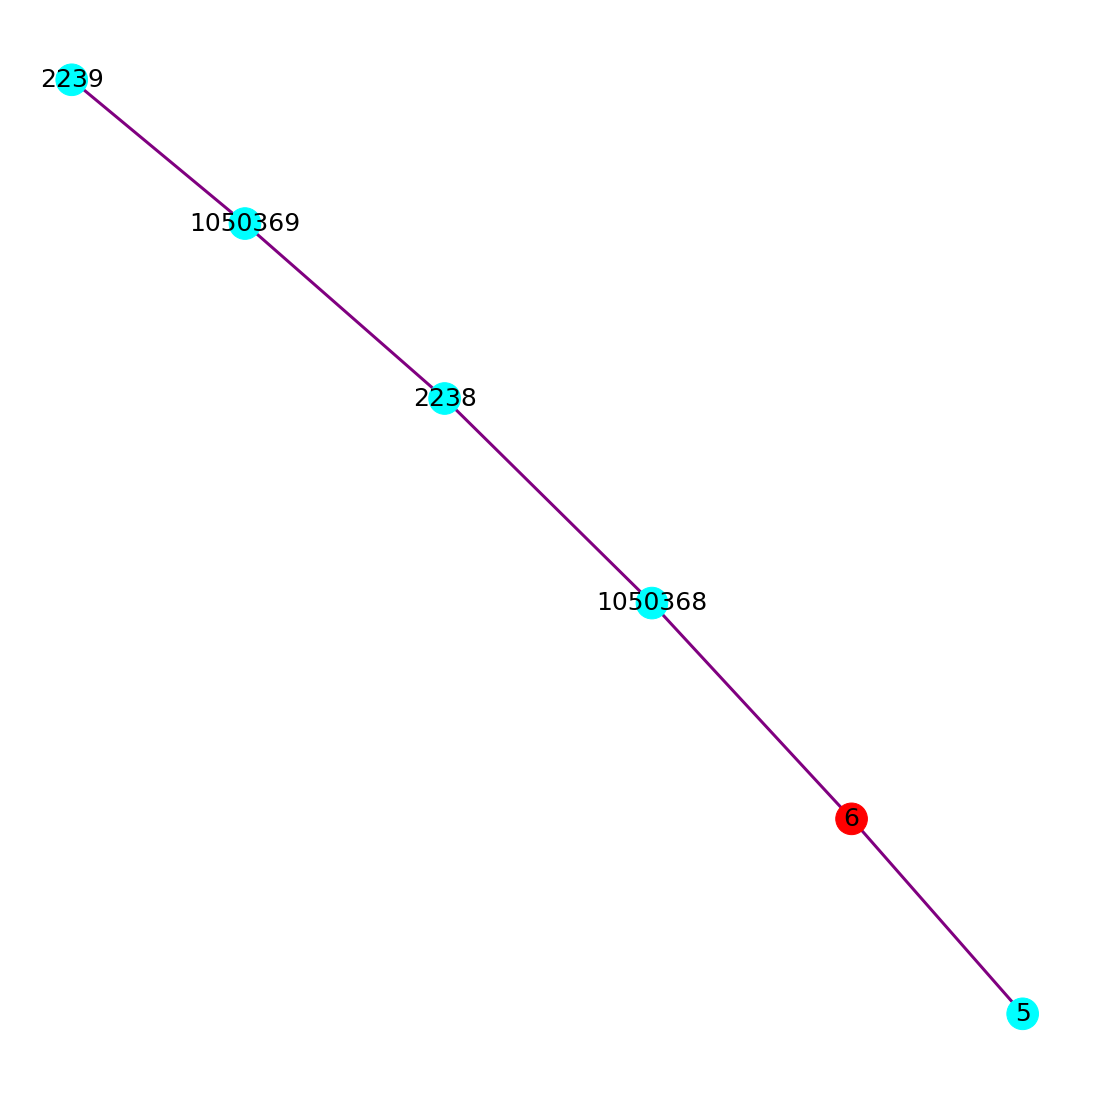

In [81]:
v=6
d=45333
nodeList=[]
typeDistance="Time"
result=getNeigh(v,nodeList,d,typeDistance)
print("The result of functionality 1:")
print(result)
drawGraph_Func1(result,typeDistance)

#### Metres distance - 'Distance'

The result of functionality 1:
[6, 5, 2244, 1048581, 1050368, 2238, 1050369, 2237, 2229, 2239, 1050370, 2605, 2240, 1050665, 2606, 2872]


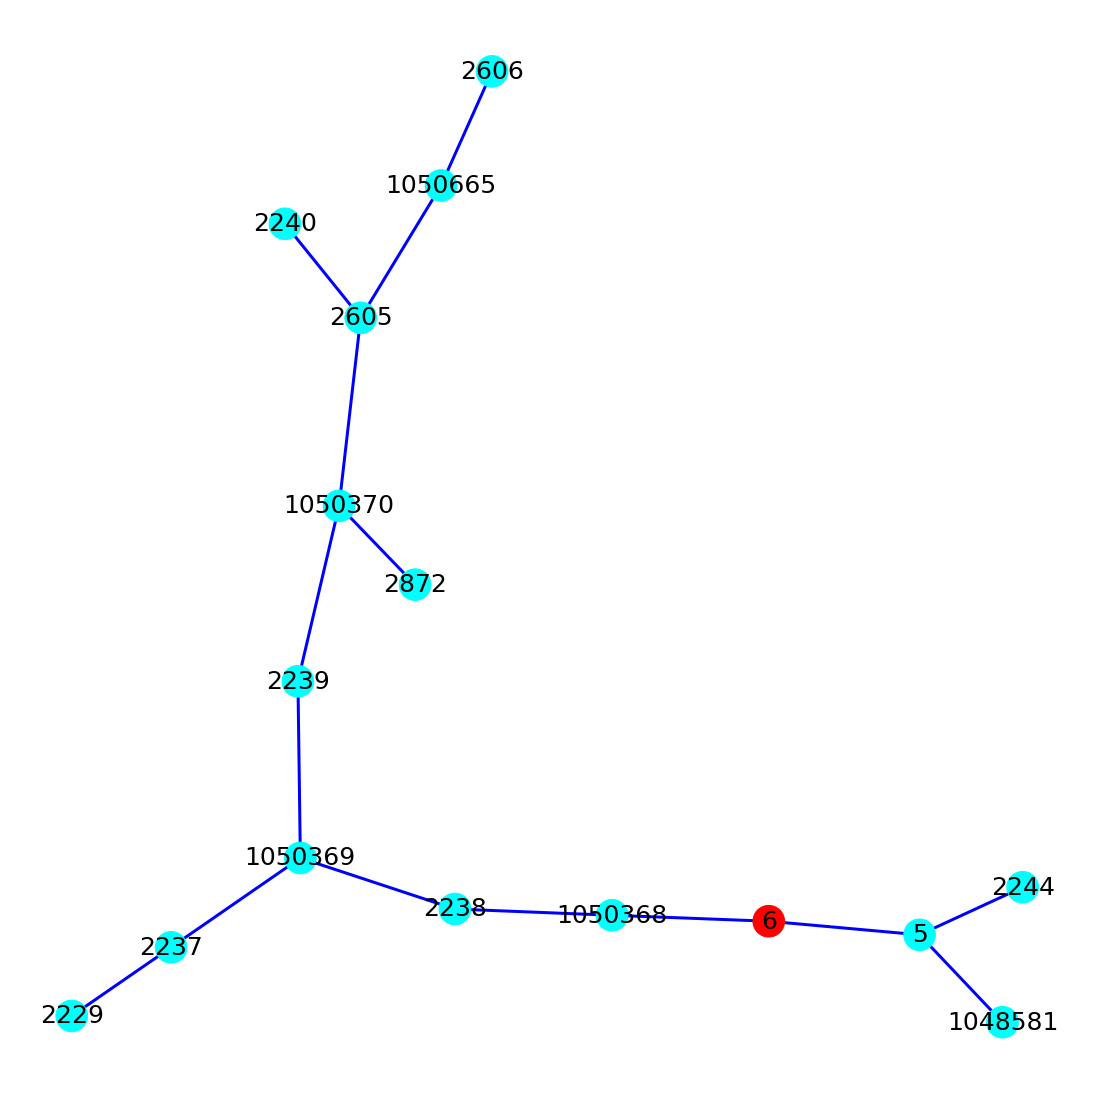

In [82]:
v=6
d=25000
typeDistance="Distance"
nodeList=[]
result=getNeigh(v,nodeList,d,typeDistance)
print("The result of functionality 1:")
print(result)
drawGraph_Func1(result,typeDistance)


#### Network distance (i.e. consider all edges to have weight equal to 1) - 'NetworkDistance'

The result of functionality 1:
[6, 5, 2244, 1050375, 2247, 2252, 1048581, 8, 1050376, 2246, 1050368, 2238, 1050369, 2237, 2229, 2239, 1050370]


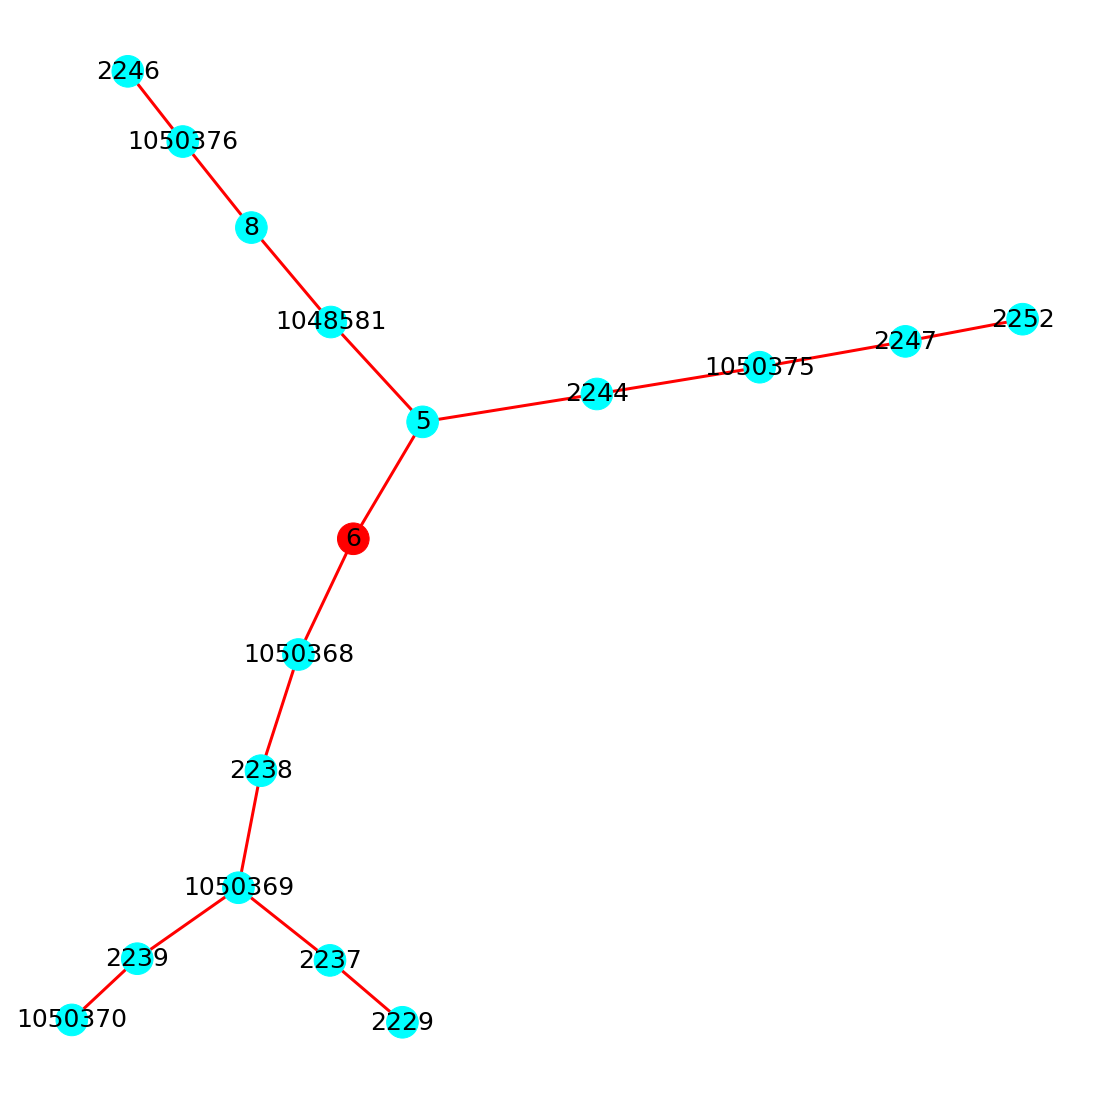

In [83]:
v=6
nodeList=[]
d=5
typeDistance="NetworkDistance"
result=getNeigh(v,nodeList,d,typeDistance)
print("The result of functionality 1:")
print(result)
drawGraph_Func1(result,typeDistance)

# Result: Functionality 2 - Visualization 2

We call 'smartest_network' fucntion that needs the following four parameters:

* <b> set_nodes </b> is a list of nodes
* <b> typeDistance </b> stay for the type of distance that we want to consider. As it is written in homework track we have t(x,y), d(x,y) and network distance. <i>"Time" </i> stay for t(x,y), <i>"Distance"</i> stay for d(x,y) and <i>" " (i.e. empty string)</i> stay for network distance. 

Then we have 3 different execution of 'smartest_network' function with different type of distance.

#### Time distance - 'Time'

The result of functionality 2:
{(2238, 1050368), (1050368, 6), (2237, 1050369), (1050369, 2238), (6, 5), (2239, 1050369)}
<class 'set'>


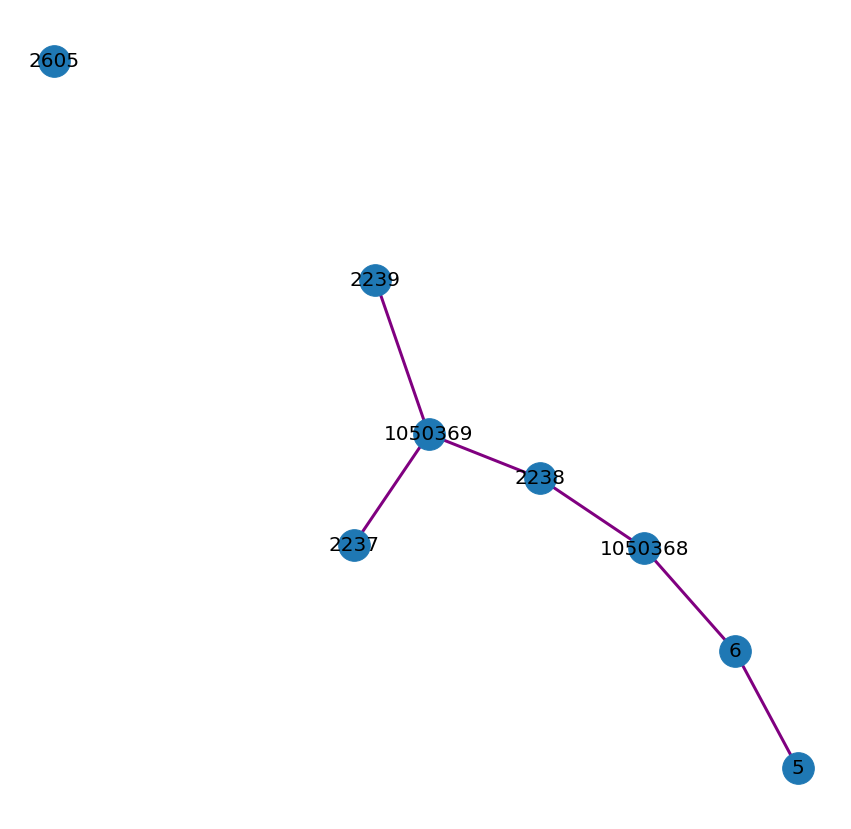

In [84]:
set_nodes=[5,6,1050368,2238,1050369,2237,2239,2605]
typeDistance="Time"
result=CAL.smartest_network(set_nodes,typeDistance)
print("The result of functionality 2:")
print(result)
drawGraph_Func2(result,typeDistance,set_nodes)

#### Metres distance - 'Distance'

The result of functionality 2:
{(2238, 1050368), (1050368, 6), (2237, 1050369), (1050369, 2238), (6, 5), (2239, 1050369)}
<class 'set'>


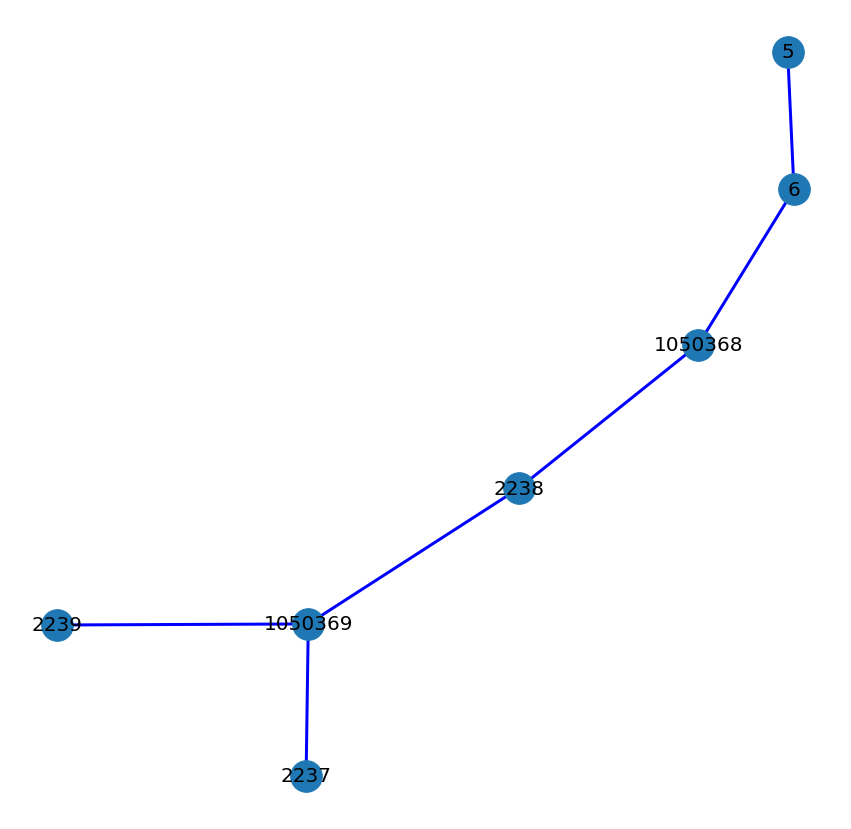

In [85]:
set_nodes=[5,6,1050368,2238,1050369,2237,2239]
typeDistance="Distance"
result=CAL.smartest_network(set_nodes,typeDistance)
print("The result of functionality 2:")
print(result)
drawGraph_Func2(result,typeDistance,set_nodes)

#### Network distance (i.e. consider all edges to have weight equal to 1) - 'NetworkDistance'

The result of functionality 2:
{(2238, 1050368), (1050368, 6), (2237, 1050369), (1050369, 2238), (6, 5), (2239, 1050369)}
<class 'set'>


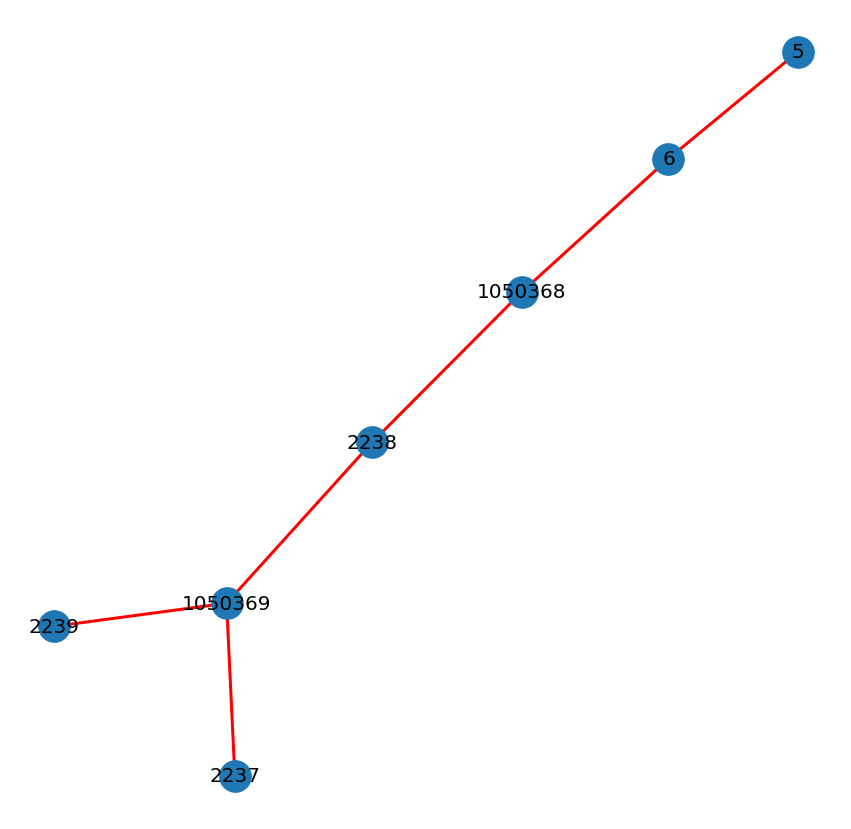

In [86]:
set_nodes=[5,6,1050368,2238,1050369,2237,2239]
typeDistance=""
result=CAL.smartest_network(set_nodes,typeDistance)
print("The result of functionality 2:")
print(result)
drawGraph_Func2(result,typeDistance,set_nodes)

## Result: functionality 3 - Visualization 3

We call 'shortest_ordered_route' fucntion that needs the following four parameters:

* <b> set_nodes </b> is a sequence of nodes
* <b> node </b> is the initial node 

Then we have a single execution of 'shortest_ordered_route' function with different type of distance.

In [93]:
node=5
set_node=[1050369,2237]
result=CAL.shortest_ordered_route(node,set_node)
print("The result of functionality 3:")
print(result)

The result of functionality 3:
[5, 6, 1050368, 2238, 1050369, 2237]


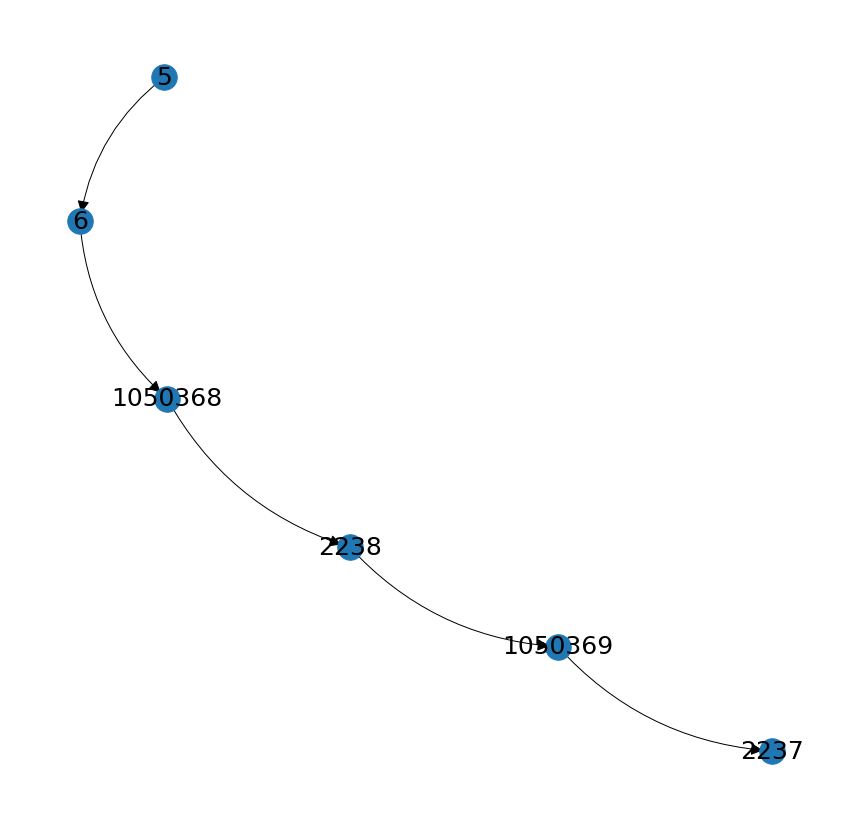

In [95]:
drawGraph(result)

# Result: Functionality 4 - Visualization 4

We call 'shortest_route' fucntion that needs the following four parameters:

* <b> set_nodes </b> is a sequence of nodes
* <b> node </b> is the initial node 

Then we have a single execution of 'shortest_route' function with different type of distance.

The result of functionlity 4:
[1048581, 5, 6, 1050368, 2238, 1050369, 2239, 1050370, 2872]


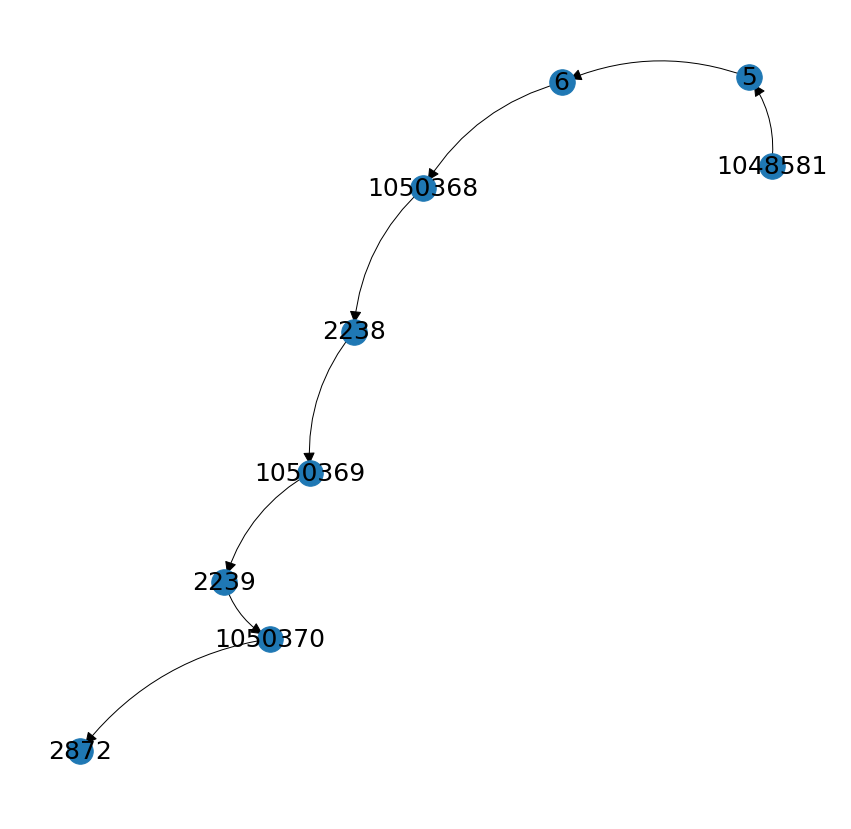

In [98]:
node=1048581
set_node=[6,2239,2872]
result=CAL.shortest_route(node,set_node)
print("The result of functionlity 4:")
print(result)
drawGraph(result)
